In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd

import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16


In [2]:
import os
import pandas as pd

# Load your DataFrame
all_xray_df = pd.read_csv(r'C:\Users\Nilesh\mini_project_workspace\Data_Entry_2017.csv')

# Initialize an empty dictionary to store the image paths
all_image_paths = {}

# Define all the image directories
image_dirs = [
    r'C:\Users\Nilesh\mini_project_workspace\images_001\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_002\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_003\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_004\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_005\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_006\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_007\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_008\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_009\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_010\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_011\images',
    r'C:\Users\Nilesh\mini_project_workspace\images_012\images',
]

# Loop over the directories and add each image to the dictionary
for image_dir in image_dirs:
    for filename in os.listdir(image_dir):
        # Create a full path for each image
        full_path = os.path.join(image_dir, filename)
        # Add it to the dictionary with the filename as the key
        all_image_paths[filename] = full_path

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

# Map the 'Image Index' column to the paths in the dictionary
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths)

# Show sample of DataFrame
all_xray_df.sample(5)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
94904,00024627_000.png,No Finding,0,24627,39,F,PA,2500,2048,0.168,0.168,NaN,C:\Users\Nilesh\mini_project_workspace\images_...
45274,00011605_019.png,No Finding,19,11605,46,F,AP,3056,2544,0.139,0.139,NaN,C:\Users\Nilesh\mini_project_workspace\images_...
85208,00021006_027.png,Pneumothorax,27,21006,71,M,PA,2992,2991,0.143,0.143,NaN,C:\Users\Nilesh\mini_project_workspace\images_...
8488,00002248_007.png,Atelectasis|Consolidation|Effusion|Mass,7,2248,62,F,PA,2992,2991,0.143,0.143,NaN,C:\Users\Nilesh\mini_project_workspace\images_...
54848,00013726_002.png,No Finding,2,13726,53,M,PA,2992,2991,0.143,0.143,NaN,C:\Users\Nilesh\mini_project_workspace\images_...


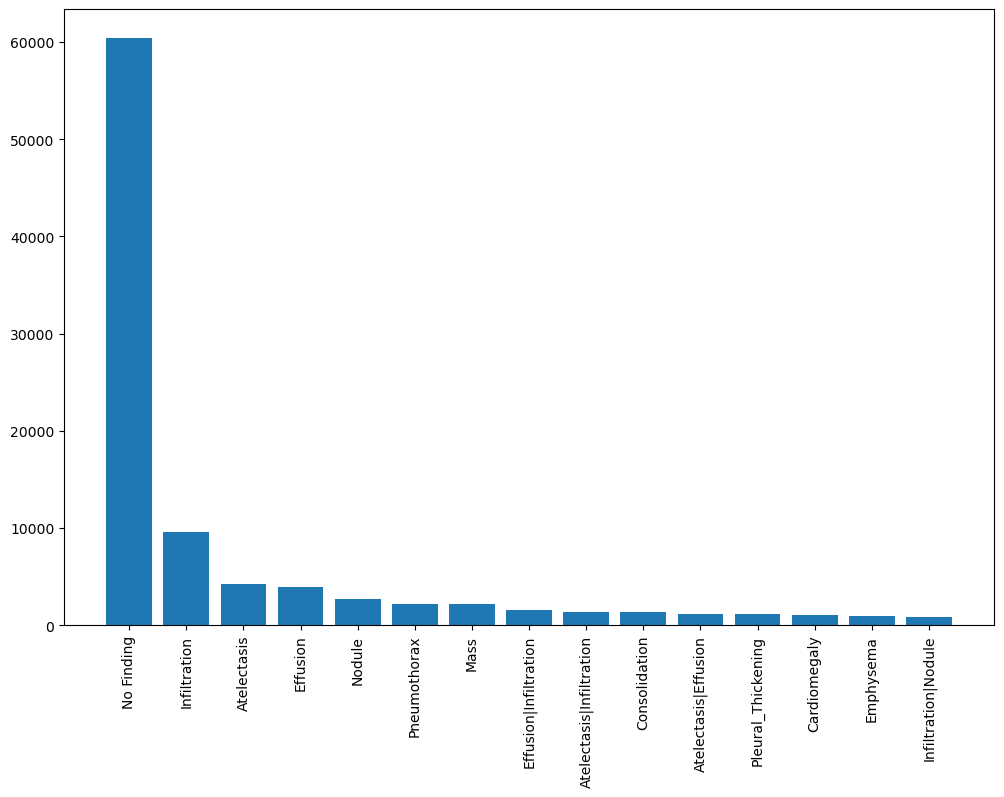

In [3]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(5)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
98500,00026031_002.png,,2,26031,33,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14900,00003890_004.png,,4,3890,68,M,PA,2422,2745,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93995,00023796_000.png,,0,23796,41,F,PA,2678,2257,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69759,00017197_002.png,Fibrosis|Infiltration,2,17197,47,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
111034,00030300_010.png,Atelectasis|Infiltration|Pleural_Thickening,10,30300,53,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


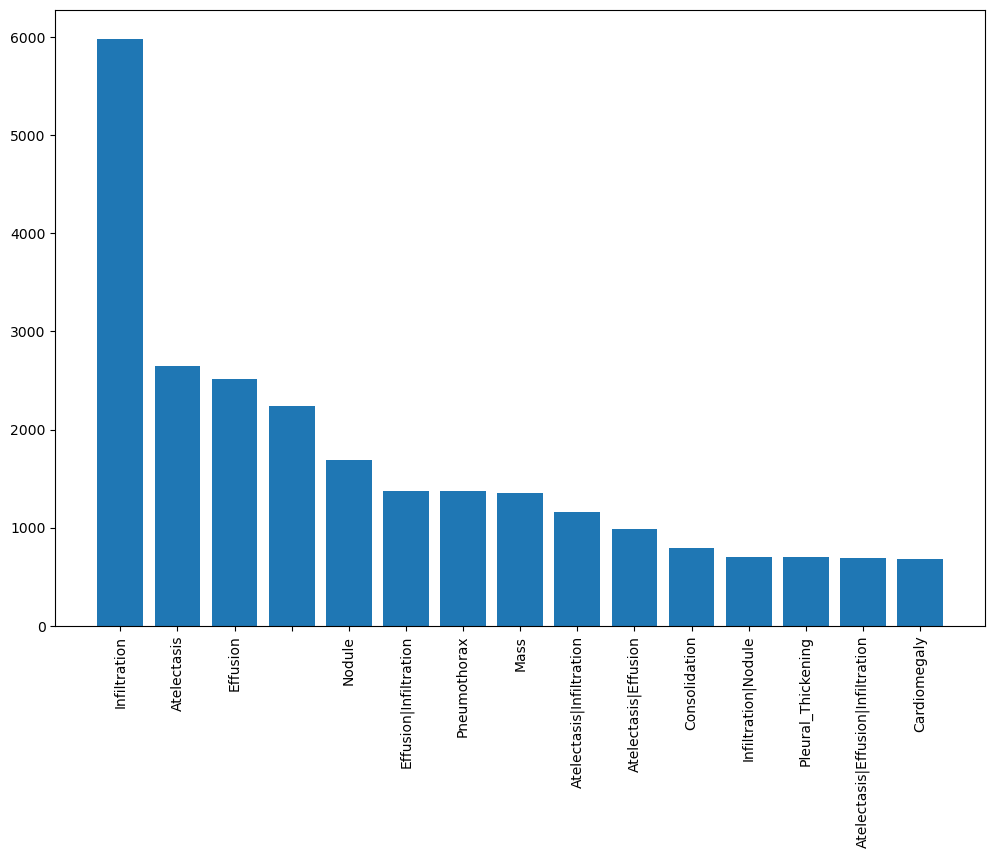

In [6]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

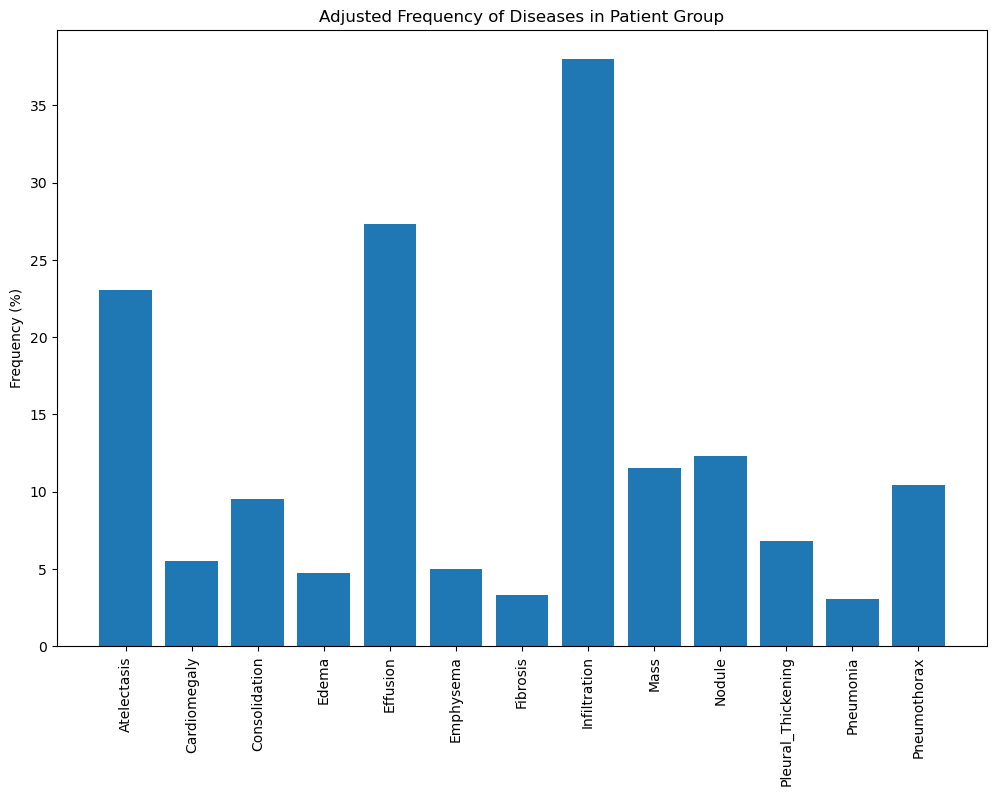

In [7]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Count the occurrences of each label combination
label_counts = all_xray_df['Finding Labels'].value_counts()

# Filter for classes with only one instance
rare_classes = label_counts[label_counts == 1].index

# Remove rows with rare classes
filtered_xray_df = all_xray_df[~all_xray_df['Finding Labels'].isin(rare_classes)]

# Proceed with train-test split on the filtered DataFrame
train_df, valid_df = train_test_split(filtered_xray_df, 
                                      test_size=0.25, 
                                      random_state=2018,
                                      stratify=filtered_xray_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'validation', valid_df.shape[0])



train 29760 validation 9920


In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(path, target_size=(224, 224)):
    img = load_img(path, target_size=target_size)
    img = img_to_array(img)
    img = img / 255.0  # Normalize to [0, 1]
    return img

train_images = np.array([load_and_preprocess_image(path) for path in train_df['path']])
valid_images = np.array([load_and_preprocess_image(path) for path in valid_df['path']])

import gc
gc.collect()

8577

In [10]:

# Convert labels to numpy arrays
train_labels = train_df[all_labels].values
valid_labels = valid_df[all_labels].values


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator for training
train_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalization
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col=all_labels,
    target_size=(224, 224),  # Adjust as needed
    batch_size=32,
    class_mode='raw',      # Use 'categorical' if you have only one label per sample
    color_mode='rgb'
)

# Create a data generator for validation
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='path',
    y_col=all_labels,
    target_size=(224, 224),  # Adjust as needed
    batch_size=32,
    class_mode='raw',  # Use 'categorical' if you have only one label per sample
    color_mode='rgb'
)


Found 29760 validated image filenames.
Found 9920 validated image filenames.


In [12]:
from tensorflow.keras import models, layers

# Define the input shape for images
input_shape = (224, 224, 3)

# Base model with convolutional layers for image feature extraction
base_model = models.Sequential([
    layers.Input(shape=input_shape),  # Input layer for image data
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),  # Use GlobalAveragePooling2D for 2D data
])

# Full model
model = models.Sequential([
    base_model,                       # Pretrained model or your base model
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),              # Add dropout to prevent overfitting
    layers.Dense(len(all_labels), activation='sigmoid')  # Output layer for multilabel classification
])


In [27]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy',  # Use binary cross-entropy for multi-label classification
              metrics=['accuracy', AUC()])


In [29]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128)            │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
 history = model.fit(
            train_generator,  # Use the generator here
            validation_data=valid_generator,
            epochs=10,
            verbose=2
        )

Epoch 1/10


C:\Users\Nilesh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


930/930 - 1645s - 2s/step - accuracy: 0.1958 - auc_1: 0.7134 - loss: 0.3432 - val_accuracy: 0.1990 - val_auc_1: 0.7439 - val_loss: 0.3284
Epoch 2/10
930/930 - 894s - 962ms/step - accuracy: 0.2001 - auc_1: 0.7346 - loss: 0.3314 - val_accuracy: 0.1990 - val_auc_1: 0.7491 - val_loss: 0.3258
Epoch 3/10
930/930 - 794s - 854ms/step - accuracy: 0.1995 - auc_1: 0.7409 - loss: 0.3291 - val_accuracy: 0.1990 - val_auc_1: 0.7514 - val_loss: 0.3251
Epoch 4/10
930/930 - 797s - 857ms/step - accuracy: 0.1998 - auc_1: 0.7444 - loss: 0.3277 - val_accuracy: 0.1990 - val_auc_1: 0.7535 - val_loss: 0.3242
Epoch 5/10
930/930 - 762s - 820ms/step - accuracy: 0.2000 - auc_1: 0.7471 - loss: 0.3267 - val_accuracy: 0.1990 - val_auc_1: 0.7543 - val_loss: 0.3244
Epoch 6/10
930/930 - 750s - 806ms/step - accuracy: 0.1998 - auc_1: 0.7485 - loss: 0.3260 - val_accuracy: 0.1990 - val_auc_1: 0.7559 - val_loss: 0.3234
Epoch 7/10
930/930 - 743s - 799ms/step - accuracy: 0.1998 - auc_1: 0.7498 - loss: 0.3256 - val_accuracy: 0.

In [36]:
# Evaluate on validation data
val_loss, val_accuracy, val_auc = model.evaluate(valid_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation AUC: {val_auc}')


310/310 ━━━━━━━━━━━━━━━━━━━━ 119s 383ms/step - accuracy: 0.1967 - auc_1: 0.7592 - loss: 0.3235
Validation Loss: 0.32248884439468384, Validation Accuracy: 0.19899193942546844, Validation AUC: 0.7588777542114258


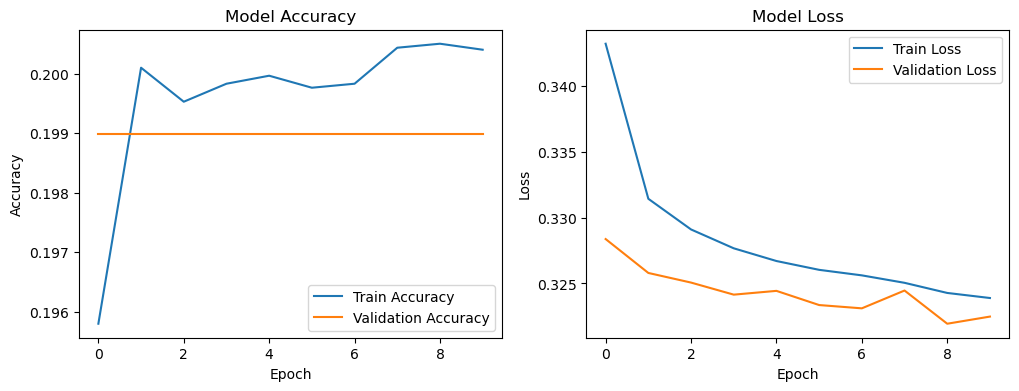

In [39]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [41]:
model.save('nilesh.h5')

In [70]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('nilesh.h5')
